In [3]:
import matplotlib.pyplot as plt
from pathlib import Path

import psignifit as ps
import psignifit.psigniplot as psp
import csv
import pandas as pd
import numpy as np

# Importing and visualising the data

In [4]:
'''
filename = "Pulfrich_lecturer1_noshading_1m_20260127_145515.csv"
fields = ["distance_m", "response"]
rows = []

df = pd.read_csv(filename, names = fields, header=0, usecols=[1,2])

aggregated_data = df.groupby(['distance_m']).agg(
    n_correct = ('response', lambda x: (x == 'BEHIND').sum()),
    n_total = ('distance_m', 'count')
)

# where n_correct is the number of BEFORE responses
data = aggregated_data.reset_index()
'''

'\nfilename = "Pulfrich_lecturer1_noshading_1m_20260127_145515.csv"\nfields = ["distance_m", "response"]\nrows = []\n\ndf = pd.read_csv(filename, names = fields, header=0, usecols=[1,2])\n\naggregated_data = df.groupby([\'distance_m\']).agg(\n    n_correct = (\'response\', lambda x: (x == \'BEHIND\').sum()),\n    n_total = (\'distance_m\', \'count\')\n)\n\n# where n_correct is the number of BEFORE responses\ndata = aggregated_data.reset_index()\n'

In [5]:
'''df.head()'''

'df.head()'

In [6]:
'''aggregated_data.head()'''

'aggregated_data.head()'

In [7]:
'''
result = ps.psignifit(data, experiment_type='yes/no')

plt.figure()
psp.plot_psychometric_function(result, x_label = "Distance behind checkerboard (m)", y_label = "Proportion of 'behind' answers")
plt.show()
'''

'\nresult = ps.psignifit(data, experiment_type=\'yes/no\')\n\nplt.figure()\npsp.plot_psychometric_function(result, x_label = "Distance behind checkerboard (m)", y_label = "Proportion of \'behind\' answers")\nplt.show()\n'

# Analysis for multiple datasets

In [61]:
# load data
data_dir = data_dir = Path.cwd()
filenames = list(data_dir.glob("*.csv"))

# group files by participant
grouped = {}  

for f in filenames:
    parts = f.stem.split("_")

    if "withshading" in parts:
        condition = "withshading"
        idx = parts.index("withshading")
    elif "noshading" in parts:
        condition = "noshading"
        idx = parts.index("noshading")
    else:
        continue

    full_name = "_".join(parts[:idx])
    name = full_name[-1]
    grouped.setdefault(name, {})[condition] = {
        "file": f
    }

In [62]:
def analyze_and_plot(ax, filename, title):
    fields = ["distance_m", "response"]

    df = pd.read_csv(
        filename,
        names=fields,
        header=0,
        usecols=[1, 2]
    )

    aggregated_data = df.groupby("distance_m").agg(
        n_correct=("response", lambda x: (x == "BEHIND").sum()),
        n_total=("distance_m", "count")
    )

    data = aggregated_data.reset_index()
    result = ps.psignifit(data, experiment_type="yes/no")

    # plot
    plt.sca(ax)
    psp.plot_psychometric_function(result, x_label="", y_label="")

    # annotate threshold
    x_thr, ci_dict = result.threshold(0.5)
    ax.annotate(
        f"{x_thr * 100:.1f} cm",
        xy=(x_thr, 0.5),
        xytext=(30, -50),
        textcoords="offset points",
        ha="center"
    )

    
    ax.set_title(title)

    return x_thr, ci_dict

KeyboardInterrupt: 

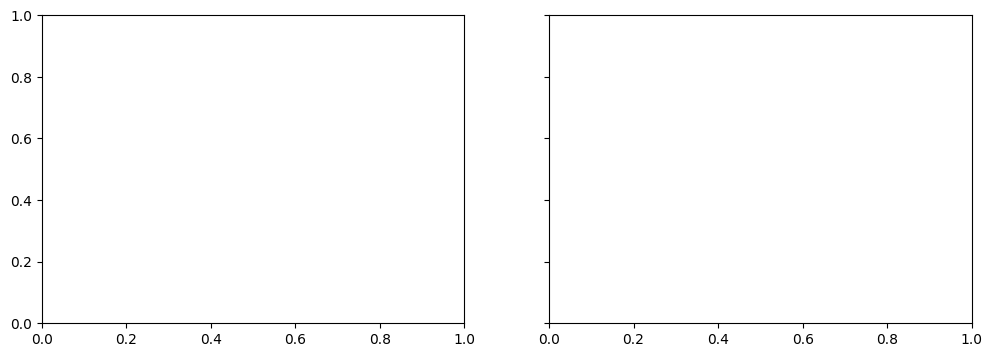

In [60]:
# loop over all participants and plot their data
for name, paths in grouped.items():

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    x_no, ci_no = analyze_and_plot(
        axes[0],
        paths["noshading"]["file"],
        f"control (no shading)"
    )
    paths["noshading"]["threshold_m"] = x_no
    paths["noshading"]["threshold_cm"] = x_no * 100
    paths["noshading"]["ci"] = ci_no

    x_ws, ci_ws = analyze_and_plot(
        axes[1],
        paths["withshading"]["file"],
        f"with filter (90% darker)"
    )
    paths["withshading"]["threshold_m"] = x_ws
    paths["withshading"]["threshold_cm"] = x_ws * 100
    paths["withshading"]["ci"] = ci_ws

    fig.supxlabel("Distance behind checkerboard (m)")
    fig.supylabel("Proportion of 'behind' answers (%)")

    fig.suptitle(f"Participant {name}")
    fig.tight_layout()
    plt.show()

In [ ]:
from pprint import pprint
pprint(grouped)

{'1': {'noshading': {'ci': {'0.68': [-0.026569395842890912,
                                     -0.01562886032974061],
                            '0.9': [-0.03055796606574197,
                                    -0.012024690012337634],
                            '0.95': [-0.03264720235432907,
                                     -0.010223678368809984]},
                     'file': WindowsPath('c:/Users/corne/uni/vr-pulfrich/Analysis/participant1_noshading_20260130_110339_Pulfrich.csv'),
                     'threshold_cm': -2.0014922274948392,
                     'threshold_m': -0.02001492227494839},
       'withshading': {'ci': {'0.68': [0.0203458479064236, 0.03840140090350121],
                              '0.9': [0.012702807787249599,
                                      0.044785847919623034],
                              '0.95': [0.008452598350767315,
                                       0.04868294510315117]},
                       'file': WindowsPath('c:/Users/corne/uni

In [ ]:
# compile results into a DataFrame
# control_thr_m: the distance threshold (in meters) for the control condition
# control_thr_cm: the distance threshold (in centimeters) for the control condition
# filter_thr_m: the distance threshold (in meters) for the filter condition
# filter_thr_cm: the distance threshold (in centimeters) for the filter condition
# ci_0.95_lowerborder, ci_0.95_upperborder: confidence interval borders for 95% CI
# ci_0.9_lowerborder, ci_0.9_upperborder: confidence interval borders for 90% CI
# ci_0.68_lowerborder, ci_0.68_upperborder: confidence interval borders for 68% CI
# distance_m, distance_cm: difference in thresholds between filter and control conditions (filter - control)
rows = []

for participant, conds in grouped.items():
    ctrl = conds.get("noshading")
    filt = conds.get("withshading")

    # Skip if a participant is missing a condition
    if ctrl is None or filt is None:
        continue

    row = {
        "participant": participant,

        "control_thr_m": ctrl.get("threshold_m", np.nan),
        "control_thr_cm": ctrl.get("threshold_cm", np.nan),

        "filter_thr_m": filt.get("threshold_m", np.nan),
        "filter_thr_cm": filt.get("threshold_cm", np.nan),
    }

    # pick CI dict (common choice: control CI; change to filt["ci"] if you prefer)
    ci = ctrl.get("ci", {})

    # helper to safely read CI bounds
    def ci_bounds(level):
        bounds = ci.get(level, [np.nan, np.nan])
        return bounds[0], bounds[1]

    row["ci_0.95_lowerborder"], row["ci_0.95_upperborder"] = ci_bounds("0.95")
    row["ci_0.9_lowerborder"],  row["ci_0.9_upperborder"]  = ci_bounds("0.9")
    row["ci_0.68_lowerborder"], row["ci_0.68_upperborder"] = ci_bounds("0.68")

    rows.append(row)

df = pd.DataFrame(rows)

# distances: filter - control (change sign if you want control - filter)
df["distance_m"]  = df["filter_thr_m"]  - df["control_thr_m"]
df["distance_cm"] = df["filter_thr_cm"] - df["control_thr_cm"]

df

,participant,control_thr_m,control_thr_cm,filter_thr_m,filter_thr_cm,ci_0.95_lowerborder,ci_0.95_upperborder,ci_0.9_lowerborder,ci_0.9_upperborder,ci_0.68_lowerborder,ci_0.68_upperborder,distance_m,distance_cm
0,1,-0.020015,-2.001492,0.033849,3.384865,-0.032647,-0.010224,-0.030558,-0.012025,-0.026569,-0.015629,0.053864,5.386358
1,2,0.006406,0.640640,0.106976,10.697598,-0.008388,0.024304,-0.005986,0.020626,-0.001187,0.014047,0.100570,10.056958
2,3,0.013123,1.312337,0.046362,4.636239,-0.000584,0.025629,0.001684,0.023195,0.006033,0.018591,0.033239,3.323902
3,4,-0.010561,-1.056113,0.009081,0.908067,-0.032901,0.007124,-0.028946,0.004224,-0.021467,-0.001626,0.019642,1.964180
4,5,-0.025873,-2.587328,-0.040087,-4.008687,-0.067384,-0.041364,-0.059606,-0.035249,-0.046044,-0.029454,-0.014214,-1.421359
5,6,-0.013636,-1.363637,0.053667,5.366729,-0.026053,-0.003755,-0.024000,-0.005569,-0.020108,-0.009217,0.067304,6.730366
6,7,-0.003084,-0.308421,0.063181,6.318124,-0.015806,0.007276,-0.013734,0.005225,-0.009804,0.001377,0.066265,6.626545


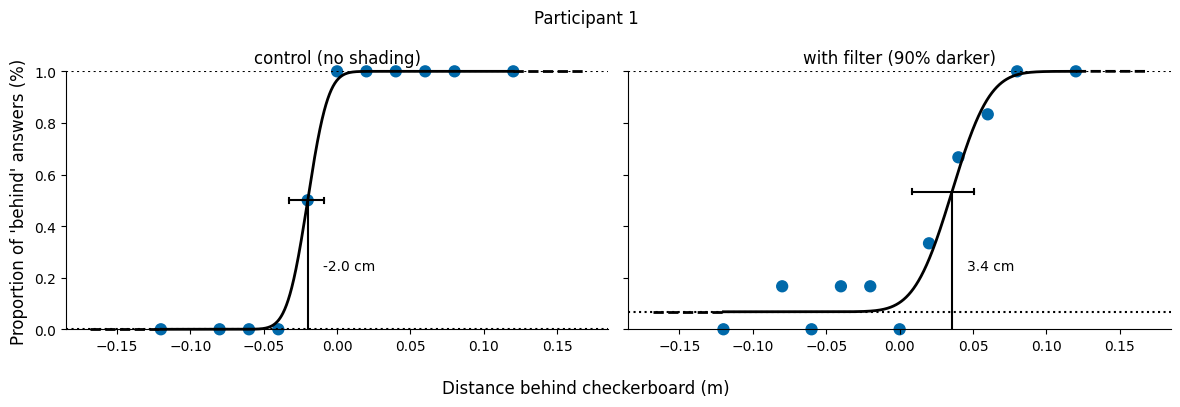

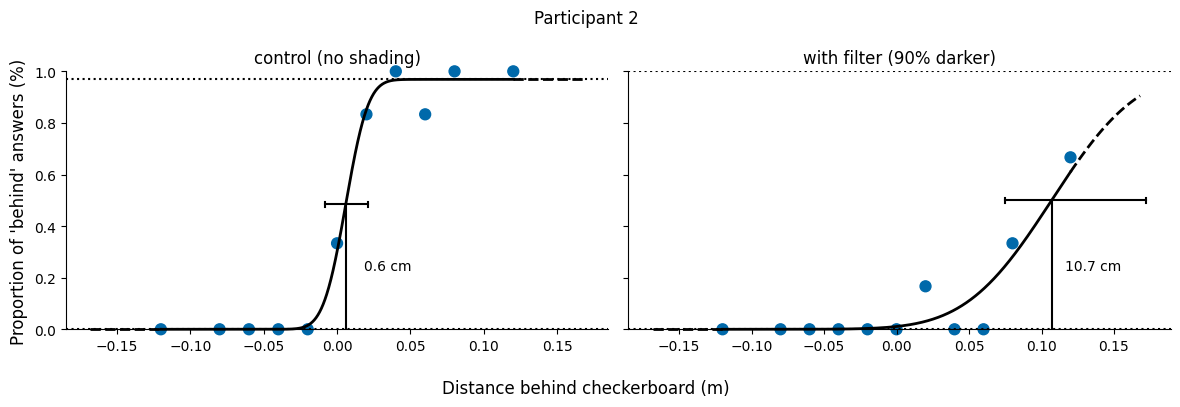

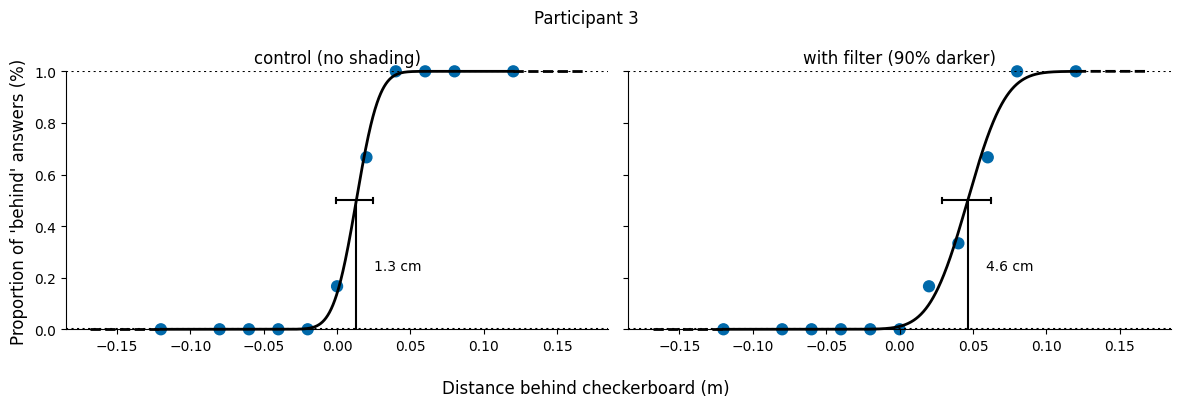

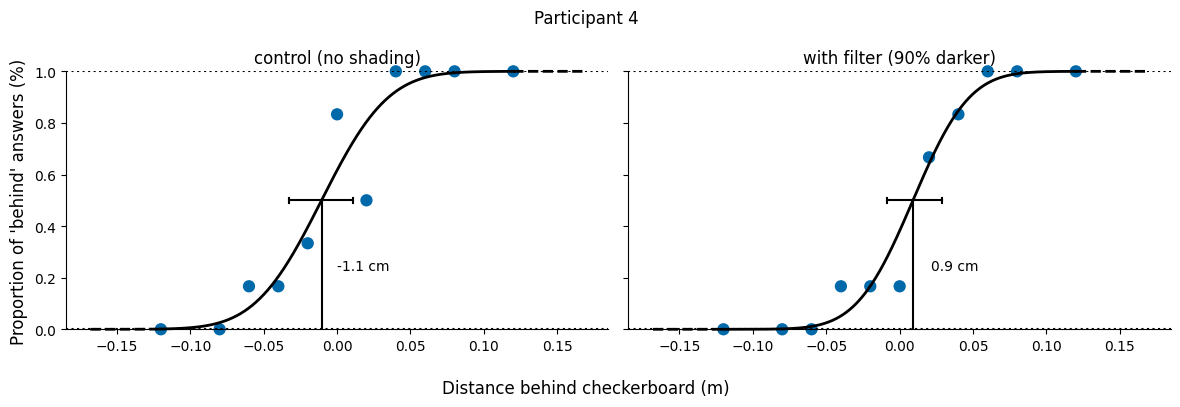

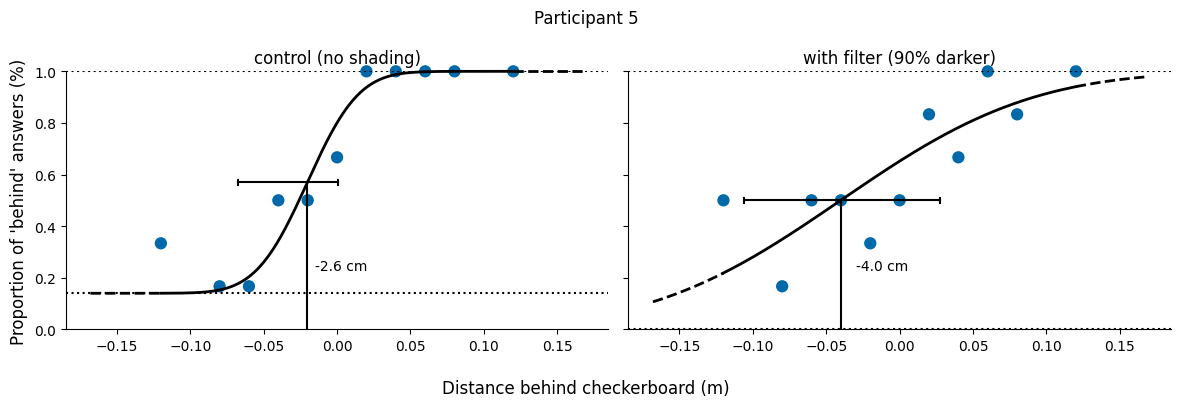

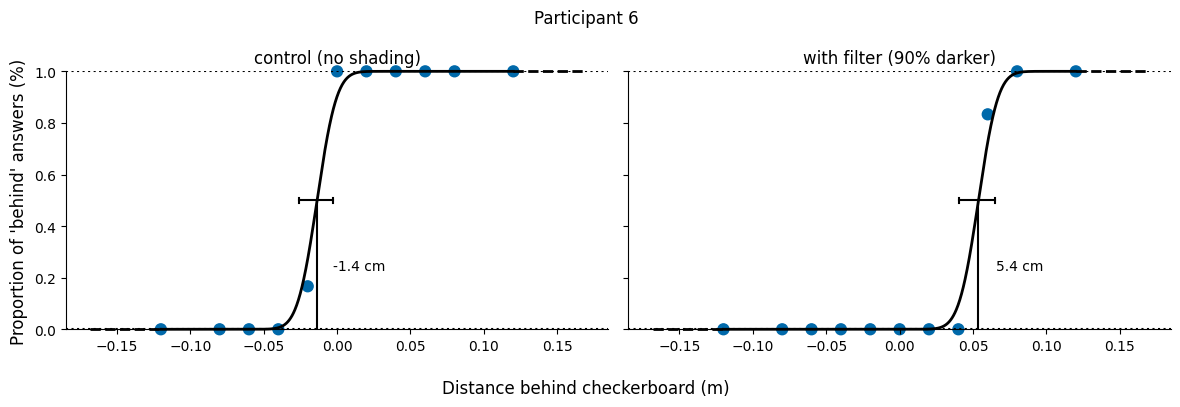

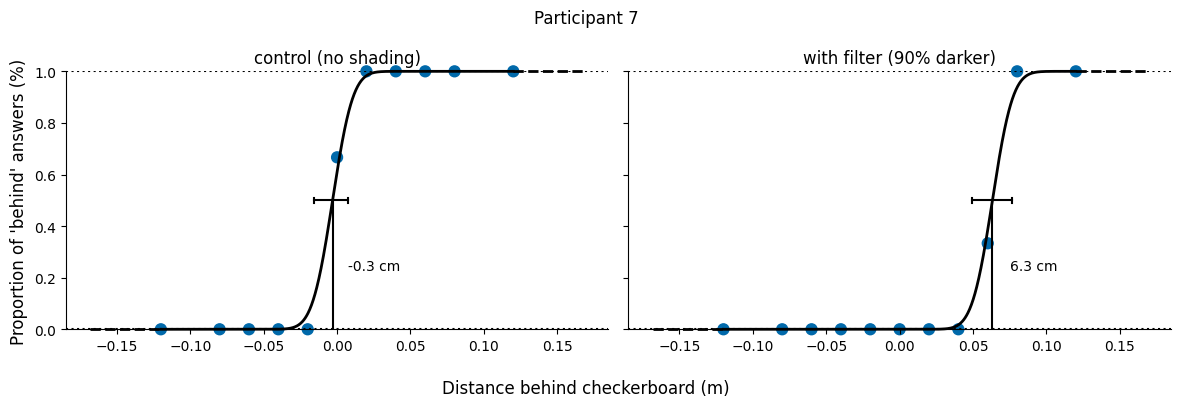

,participant,control_thr_m,control_thr_cm,filter_thr_m,filter_thr_cm,ci_0.95_lowerborder,ci_0.95_upperborder,ci_0.9_lowerborder,ci_0.9_upperborder,ci_0.68_lowerborder,ci_0.68_upperborder,distance_m,distance_cm
0,1,-0.020015,-2.001492,0.033849,3.384865,-0.032647,-0.010224,-0.030558,-0.012025,-0.026569,-0.015629,0.053864,5.386358
1,2,0.006406,0.640640,0.106976,10.697598,-0.008388,0.024304,-0.005986,0.020626,-0.001187,0.014047,0.100570,10.056958
2,3,0.013123,1.312337,0.046362,4.636239,-0.000584,0.025629,0.001684,0.023195,0.006033,0.018591,0.033239,3.323902
3,4,-0.010561,-1.056113,0.009081,0.908067,-0.032901,0.007124,-0.028946,0.004224,-0.021467,-0.001626,0.019642,1.964180
4,5,-0.025873,-2.587328,-0.040087,-4.008687,-0.067384,-0.041364,-0.059606,-0.035249,-0.046044,-0.029454,-0.014214,-1.421359
5,6,-0.013636,-1.363637,0.053667,5.366729,-0.026053,-0.003755,-0.024000,-0.005569,-0.020108,-0.009217,0.067304,6.730366
6,7,-0.003084,-0.308421,0.063181,6.318124,-0.015806,0.007276,-0.013734,0.005225,-0.009804,0.001377,0.066265,6.626545


In [63]:
rows = []

for name, paths in grouped.items():
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    x_no, ci_no = analyze_and_plot(
        axes[0],
        paths["noshading"]["file"],
        "control (no shading)"
    )

    x_ws, ci_ws = analyze_and_plot(
        axes[1],
        paths["withshading"]["file"],
        "with filter (90% darker)"
    )

    # choose which CI dict to store (control here)
    ci = ci_no

    rows.append({
        "participant": name,

        "control_thr_m": x_no,
        "control_thr_cm": x_no * 100,

        "filter_thr_m": x_ws,
        "filter_thr_cm": x_ws * 100,

        "ci_0.95_lowerborder": ci["0.95"][0],
        "ci_0.95_upperborder": ci["0.95"][1],
        "ci_0.9_lowerborder":  ci["0.9"][0],
        "ci_0.9_upperborder":  ci["0.9"][1],
        "ci_0.68_lowerborder": ci["0.68"][0],
        "ci_0.68_upperborder": ci["0.68"][1],

        "distance_m":  x_ws - x_no,
        "distance_cm": (x_ws - x_no) * 100,
    })

    fig.supxlabel("Distance behind checkerboard (m)")
    fig.supylabel("Proportion of 'behind' answers (%)")
    fig.suptitle(f"Participant {name}")
    fig.tight_layout()
    plt.show()

df = pd.DataFrame(rows)
df

### DataFrame:
- `control_thr_m`: the distance threshold (in meters) for the control condition
- `control_thr_cm`: the distance threshold (in centimeters) for the control condition
- `filter_thr_m`: the distance threshold (in meters) for the filter condition
- `filter_thr_cm`: the distance threshold (in centimeters) for the filter condition
- `ci_0.95_lowerborder, ci_0.95_upperborder`: confidence interval borders for 95% CI
- `ci_0.9_lowerborder, ci_0.9_upperborder`: confidence interval borders for 90% CI
- `ci_0.68_lowerborder, ci_0.68_upperborder`: confidence interval borders for 68% CI
- `distance_m, distance_cm`: difference in thresholds between filter and control conditions (filter - control), in meters and centimeters